# Estimating major event impact on German electricity prices
Notebook 01 data loading ad cleaning
___

### Table of Contents:
* [Introduction](#hading-1)
* [Data loading](#heading-2)
* [Data cleaning](#heading-3)
* [Export](#heading-4)

## Introduction <a class="anchor" id="heading-1"></a>

The following is a systematic procedure for outlier detection in time series. The present analysis relates to electricity market data, but can in principle be used for any temporal signal. The aim of this project is to analyse certain outliers in the time series with the help of machine learning models. In this notebook, the various data from the period between 2015 and 2024 are loaded, processed and cleaned. 

The following steps are carried out:

- First, the raw CSV files are loaded. 
- Then the raw files are merged and subjected to a missing value check. 
- Finally, the processed data is saved again as a CSV.

The following data blanks are processed in this step:

- Prices: Prices per €/MWh in the different price zones
- Generation: electricity generation in MWh per 15-minute time unit in Germany
- Consumption: the demand in 15-minute frequency in Germany 
- Export-Import: the physical flow of electricity to and from Germany to the various neighbouring countries
- CO2 price data: the CO2 certificate price in Europe
- Inflation data: the inflation data within the eurozone for electricity

### Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

### Definition of functions

The following functions are used in this notebook. 

In [2]:
def list_to_dictionary(list):
    '''
    Creates a list out of a dictionary 
    Example: 
    my_liste = ['Apple', 'Banana', 'Cherry']
    my_dictionary = list_to_dict(my_liste)
    {
        0:Apple,
        1:Banana,
        3:Cherry
    }
    '''
    return {index: x for index, x in enumerate(list)}


In [3]:
def df_merge(df1, df2):
    '''
    take the dataframes, create the index column start, as datetime,
    set the index to start and merge the dataframes to one dataframe 
    '''

    # Create a datetime column start in both dataframes 
    df1['Start'] = pd.to_datetime(df1['Start date'], format='%b %d, %Y %I:%M %p')
    df2['Start'] = pd.to_datetime(df2['Start date'], format='%b %d, %Y %I:%M %p')
    #set the index to 'Start' in both dfs 
    df1.set_index('Start', inplace = True)
    df2.set_index('Start', inplace = True)
    # drop old columns
    df1= df1.drop('Start date', axis=1)
    df1= df1.drop('End date', axis=1)

    df2= df2.drop('Start date', axis=1)
    df2= df2.drop('End date', axis=1)

    # sort the index before merging
    df2.sort_index(inplace = True)
    # sanity check 
    df1 = df1.loc[(df1.index < df2.index.min()),:]
    df1.sort_index(inplace = True)
    # concat both dfs to one df 
    df = pd.concat([df1, df2], axis=0)

    return df

In [4]:
def check_complete_and_ordered_index(df):
    '''
    Sanity-checker if the index is correct- checks for the range and the order of the index in a 15min time frequency 
    '''
    ideal_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15min')
    
    if not df.index.equals(ideal_index):
        missing_timestamps = ideal_index.difference(df.index)
        return missing_timestamps
    else:
        print("Index is complete and ordered")
    
    print("check done")

In [5]:
def remove_duplicate_indices_and_reindex(df):
    '''
    Removes any duplicates from the index, recreate the index
    if there are gaps and interpolate only over the gaps
    '''
    #check for duplicates, keep the first 
    duplicates = df.index.duplicated(keep='first')
    if duplicates.any():
        #remove duplicates out of the df by filtering the dataframe without the duplicates
        df = df[~duplicates]
        print("Duplicate indices removed.")
    	# create an ideal index range based on the dataframe
        ideal_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15T')
    
        # re index the dataframe with the ideal_index
        df_reindexed = df.reindex(ideal_index)
    
        #create new inserts as difference between the old index after duplicate drop and the ideal index of df_reindexed
        newly_inserted = df_reindexed.index.difference(df.index)
    
        # fill gaps only for the newly inserted rows
        df_interpolated = df_reindexed.copy()
        for col in df.columns:
            df_interpolated.loc[newly_inserted, col] = df_interpolated[col].interpolate(method='linear')
    
        return df_interpolated

    else:
        
        print("No duplicate indices found.")
        return df


In [6]:
def infaltion_interpolate(df):
    # created out of remove_duplicate_indices_and_reindex for specific use case 
    ideal_index = pd.date_range(start=Prices.index.min(), end=Prices.index.max(), freq='15T')
        
    df_reindexed = df.reindex(ideal_index)        
    # fill gaps only for the newly inserted rows
    df_interpolated = df_reindexed.interpolate(method='linear')
    return df_interpolated

___
## Data Loading <a class="anchor" id="heading-2"></a>

loading of the raw data

In [7]:
# Consumption data
Consumption_2020_2024 = pd.read_csv('../data/raw_data/Actual_consumption_202001010000_202405250100_Quarterhour.csv',na_values='-', sep=';', encoding='utf-8', thousands=',')
Consumption_2015_2020 = pd.read_csv('../data/raw_data/Actual_consumption_201501010000_202001020100_Quarterhour.csv',na_values='-', delimiter=';', encoding='utf-8',thousands=',')
# Generation data
Generation_2020_2024 = pd.read_csv('../data/raw_data/Actual_generation_202001010000_202405250100_Quarterhour.csv',na_values='-', delimiter=';', encoding='utf-8',thousands=',') 
Generation_2015_2020 = pd.read_csv('../data/raw_data/Actual_generation_201501010000_202001020100_Quarterhour.csv',na_values='-', sep=';', encoding='utf-8',thousands=',')
# Cross_Border data
Cross_Border_2020_2024 = pd.read_csv('../data/raw_data/Cross-border_physical_flows_202001010000_202405250100_Quarterhour.csv',na_values='-', delimiter=';', encoding='utf-8',thousands=',') 
Cross_Border_2015_2020 = pd.read_csv('../data/raw_data/Cross-border_physical_flows_201501010000_202001020100_Quarterhour.csv',na_values='-', delimiter=';', encoding='utf-8',thousands=',')
# # Prices data
Prices_2015_2020 = pd.read_csv('../data/raw_data/Day-ahead_prices_201501010000_202001020100_Quarterhour.csv', delimiter=';',na_values='-', encoding='utf-8',thousands=',') 
Prices_2020_2024 = pd.read_csv('../data/raw_data/Day-ahead_prices_202001010000_202405250100_Quarterhour.csv', delimiter=';',na_values='-', encoding='utf-8',thousands=',') 

In the following, the data is prepared for merging. The following steps are carried out: 

- the column 'Start date' is formatted as datetime, it becomes the index in all databases
- the column 'End date' is removed
- the dataframes 2015 to 2020 and 2020 to 2024 are merged. The index is checked for correct order, duplicates and missing digits. 

In [8]:
Generation = df_merge(Generation_2015_2020, Generation_2020_2024)
Prices = df_merge(Prices_2015_2020, Prices_2020_2024)
Export_Import = df_merge(Cross_Border_2015_2020, Cross_Border_2020_2024)
Consumption = df_merge(Consumption_2015_2020, Consumption_2020_2024)

Check if the index in each dataframe is correct.

In [9]:
check_complete_and_ordered_index(Generation)

DatetimeIndex(['2015-03-29 02:00:00', '2015-03-29 02:15:00',
               '2015-03-29 02:30:00', '2015-03-29 02:45:00',
               '2016-03-27 02:00:00', '2016-03-27 02:15:00',
               '2016-03-27 02:30:00', '2016-03-27 02:45:00',
               '2017-03-26 02:00:00', '2017-03-26 02:15:00',
               '2017-03-26 02:30:00', '2017-03-26 02:45:00',
               '2018-03-25 02:00:00', '2018-03-25 02:15:00',
               '2018-03-25 02:30:00', '2018-03-25 02:45:00',
               '2019-03-31 02:00:00', '2019-03-31 02:15:00',
               '2019-03-31 02:30:00', '2019-03-31 02:45:00',
               '2020-03-29 02:00:00', '2020-03-29 02:15:00',
               '2020-03-29 02:30:00', '2020-03-29 02:45:00',
               '2021-03-28 02:00:00', '2021-03-28 02:15:00',
               '2021-03-28 02:30:00', '2021-03-28 02:45:00',
               '2022-03-27 02:00:00', '2022-03-27 02:15:00',
               '2022-03-27 02:30:00', '2022-03-27 02:45:00',
               '2023-03-

In [10]:
Generation = remove_duplicate_indices_and_reindex(Generation)

Duplicate indices removed.


In [11]:
Consumption = remove_duplicate_indices_and_reindex(Consumption)
check_complete_and_ordered_index(Consumption)

Duplicate indices removed.
Index is complete and ordered
check done


In [12]:
Export_Import = remove_duplicate_indices_and_reindex(Export_Import)
check_complete_and_ordered_index(Export_Import)

Duplicate indices removed.
Index is complete and ordered
check done


In [13]:
Prices = remove_duplicate_indices_and_reindex(Prices)
check_complete_and_ordered_index(Prices)

Duplicate indices removed.
Index is complete and ordered
check done


### Extra data

#### CO2-Prices in €  per tonne

In addition to the electricity market data consisting of Generation, Consumption, Price and Export_Import, CO2 price and inflation data are also used.

Source:
https://tradingeconomics.com/commodity/carbon

In [14]:
svg_path ='M 0 374.485 L 1.57863 375.447 L 3.15726 374.054 L 4.73589 375.181 L 6.31452 374.286 L 7.89315 374.717 L 9.47177 372.428 L 11.0504 373.523 L 12.629 374.286 L 14.2077 375.281 L 15.7863 376.409 L 17.3649 374.485 L 18.9435 375.414 L 20.5222 374.153 L 22.1008 374.85 L 23.6794 375.181 L 25.2581 373.722 L 26.8367 373.059 L 28.4153 372.893 L 29.994 372.727 L 31.5726 373.656 L 33.1512 373.589 L 34.7298 373.324 L 36.3085 372.661 L 37.8871 373.324 L 39.4657 372.959 L 41.0444 373.291 L 42.623 372.727 L 44.2016 372.296 L 45.7802 371.4 L 47.3589 371.865 L 48.9375 372.163 L 50.5161 370.372 L 52.0948 370.77 L 53.6734 371.069 L 55.252 371.135 L 56.8306 370.571 L 58.4093 371.069 L 59.9879 371.467 L 61.5665 370.969 L 63.1452 370.306 L 64.7238 370.173 L 66.3024 369.377 L 67.8811 369.344 L 69.4597 370.107 L 71.0383 370.173 L 72.6169 369.775 L 74.1956 369.543 L 75.7742 369.742 L 77.3528 371.234 L 78.9314 371.035 L 80.5101 370.604 L 82.0887 370.505 L 83.6673 373.258 L 85.246 375.712 L 86.8246 376.906 L 88.4032 377.868 L 89.9819 379.526 L 91.5605 381.185 L 93.1391 380.853 L 94.7177 381.417 L 96.2964 381.649 L 97.875 381.417 L 99.4536 381.582 L 101.032 381.881 L 102.611 380.82 L 104.19 380.024 L 105.768 379.825 L 107.347 378.199 L 108.925 377.503 L 110.504 378.564 L 112.083 378.598 L 113.661 378.199 L 115.24 377.967 L 116.819 378.266 L 118.397 378.233 L 119.976 379.194 L 121.554 381.549 L 123.133 382.677 L 124.712 382.909 L 126.29 381.649 L 127.869 382.843 L 129.448 383.307 L 131.026 382.312 L 132.605 381.748 L 134.183 382.18 L 135.762 382.412 L 137.341 384.468 L 138.919 384.468 L 140.498 383.539 L 142.077 382.942 L 143.655 381.549 L 145.234 379.128 L 146.813 378.73 L 148.391 378.465 L 149.97 378.498 L 151.548 376.74 L 153.127 379.194 L 154.706 379.493 L 156.284 381.417 L 157.863 383.738 L 159.442 383.208 L 161.02 381.649 L 162.599 377.304 L 164.177 376.21 L 165.756 381.251 L 167.335 381.251 L 168.913 379.991 L 170.492 381.682 L 172.071 380.886 L 173.649 381.019 L 175.228 381.483 L 176.806 380.123 L 178.385 379.427 L 179.964 380.853 L 181.542 380.952 L 183.121 382.18 L 184.7 382.445 L 186.278 381.781 L 187.857 381.582 L 189.435 382.843 L 191.014 382.843 L 192.593 382.81 L 194.171 383.208 L 195.75 381.914 L 197.329 380.786 L 198.907 380.886 L 200.486 381.284 L 202.065 381.815 L 203.643 381.848 L 205.222 381.317 L 206.8 380.289 L 208.379 380.024 L 209.958 381.118 L 211.536 380.82 L 213.115 380.256 L 214.694 380.123 L 216.272 378.697 L 217.851 377.802 L 219.429 378.664 L 221.008 374.551 L 222.587 374.949 L 224.165 375.944 L 225.744 374.551 L 227.323 374.783 L 228.901 373.722 L 230.48 372.893 L 232.058 374.22 L 233.637 371.865 L 235.216 373.457 L 236.794 373.191 L 238.373 372.229 L 239.952 372.528 L 241.53 374.319 L 243.109 374.186 L 244.688 370.836 L 246.266 370.87 L 247.845 372.196 L 249.423 371.931 L 251.002 368.946 L 252.581 367.852 L 254.159 368.283 L 255.738 367.387 L 257.317 366.425 L 258.895 365.464 L 260.474 364.369 L 262.052 361.119 L 263.631 360.953 L 265.21 356.177 L 266.788 353.955 L 268.367 354.917 L 269.946 351.766 L 271.524 354.717 L 273.103 353.026 L 274.681 354.817 L 276.26 349.477 L 277.839 347.421 L 279.417 344.933 L 280.996 347.288 L 282.575 345.53 L 284.153 349.809 L 285.732 347.852 L 287.31 348.283 L 288.889 345.928 L 290.468 344.734 L 292.046 341.384 L 293.625 341.219 L 295.204 339.361 L 296.782 338.665 L 298.361 337.836 L 299.94 329.378 L 301.518 328.052 L 303.097 320.987 L 304.675 331.766 L 306.254 324.602 L 307.833 327.654 L 309.411 324.503 L 310.99 330.44 L 312.569 332.629 L 314.147 337.371 L 315.726 341.351 L 317.304 333.325 L 318.883 334.618 L 320.462 330.97 L 322.04 330.008 L 323.619 330.705 L 325.198 320.49 L 326.776 315.349 L 328.355 315.15 L 329.933 319.296 L 331.512 322.579 L 333.091 315.548 L 334.669 318.632 L 336.248 325.066 L 337.827 323.806 L 339.405 330.274 L 340.984 335.182 L 342.563 324.105 L 344.141 321.65 L 345.72 323.474 L 347.298 329.444 L 348.877 326.559 L 350.456 316.41 L 352.034 309.843 L 353.613 308.815 L 355.192 312.264 L 356.77 314.42 L 358.349 313.027 L 359.927 315.083 L 361.506 313.525 L 363.085 316.874 L 364.663 316.708 L 366.242 314.918 L 367.821 314.088 L 369.399 310.838 L 370.978 310.506 L 372.556 302.513 L 374.135 302.181 L 375.714 304.172 L 377.292 300.954 L 378.871 304.735 L 380.45 311.899 L 382.028 314.752 L 383.607 310.705 L 385.185 314.818 L 386.764 310.506 L 388.343 310.009 L 389.921 314.088 L 391.5 321.916 L 393.079 316.941 L 394.657 312.165 L 396.236 315.183 L 397.815 314.121 L 399.393 315.614 L 400.972 318.897 L 402.55 316.476 L 404.129 314.354 L 405.708 315.282 L 407.286 318.334 L 408.865 309.544 L 410.444 309.445 L 412.022 315.15 L 413.601 317.703 L 415.179 313.624 L 416.758 317.14 L 418.337 318.798 L 419.915 320.655 L 421.494 317.438 L 423.073 313.06 L 424.651 319.694 L 426.23 320.324 L 427.808 325.232 L 429.387 344.569 L 430.966 343.64 L 432.544 338.433 L 434.123 328.085 L 435.702 326.028 L 437.28 329.212 L 438.859 335.083 L 440.438 333.823 L 442.016 334.419 L 443.595 327.023 L 445.173 327.023 L 446.752 320.921 L 448.331 325.033 L 449.909 317.869 L 451.488 315.979 L 453.067 305.432 L 454.645 301.75 L 456.224 305.73 L 457.802 310.539 L 459.381 310.838 L 460.96 310.374 L 462.538 313.491 L 464.117 312.927 L 465.696 300.092 L 467.274 307.256 L 468.853 304.271 L 470.431 305.167 L 472.01 311.203 L 473.589 308.35 L 475.167 312.728 L 476.746 315.448 L 478.325 313.458 L 479.903 319.362 L 481.482 313.69 L 483.06 310.838 L 484.639 309.312 L 486.218 304.702 L 487.796 298.135 L 489.375 296.775 L 490.954 294.852 L 492.532 291.237 L 494.111 289.479 L 495.69 282.182 L 497.268 292.729 L 498.847 284.437 L 500.425 288.716 L 502.004 271.303 L 503.583 265.267 L 505.161 273.957 L 506.74 274.355 L 508.319 268.584 L 509.897 255.881 L 511.476 258.799 L 513.054 259.595 L 514.633 257.141 L 516.212 253.261 L 517.79 250.674 L 519.369 242.283 L 520.948 236.014 L 522.526 230.674 L 524.105 210.111 L 525.683 226.363 L 527.262 228.751 L 528.841 232.266 L 530.419 223.311 L 531.998 225.865 L 533.577 215.417 L 535.155 207.789 L 536.734 218.038 L 538.313 222.581 L 539.891 229.215 L 541.47 221.122 L 543.048 210.078 L 544.627 214.323 L 546.206 217.64 L 547.784 202.317 L 549.363 194.622 L 550.942 195.949 L 552.52 200.725 L 554.099 189.249 L 555.677 192.234 L 557.256 204.539 L 558.835 200.857 L 560.413 204.738 L 561.992 203.279 L 563.571 201.023 L 565.149 188.154 L 566.728 167.956 L 568.306 156.613 L 569.885 138.471 L 571.464 120.296 L 573.042 154.955 L 574.621 144.905 L 576.2 130.511 L 577.778 114.69 L 579.357 125.768 L 580.935 117.841 L 582.514 102.087 L 584.093 78.1075 L 585.671 89.9812 L 587.25 101.258 L 588.829 105.669 L 590.407 182.085 L 591.986 143.413 L 593.565 136.348 L 595.143 137.31 L 596.722 137.675 L 598.3 132.368 L 599.879 132.766 L 601.458 102.85 L 603.036 117.908 L 604.615 94.3923 L 606.194 104.541 L 607.772 131.373 L 609.351 118.737 L 610.929 109.881 L 612.508 126.498 L 614.087 124.806 L 615.665 121.29 L 617.244 114.16 L 618.823 123.413 L 620.401 114.823 L 621.98 144.938 L 623.558 137.476 L 625.137 116.879 L 626.716 103.248 L 628.294 72.9335 L 629.873 98.4718 L 631.452 139.665 L 633.03 178.835 L 634.609 154.988 L 636.188 179.863 L 637.766 176.679 L 639.345 166.331 L 640.923 172.4 L 642.502 170.079 L 644.081 128.654 L 645.659 144.739 L 647.238 146.464 L 648.817 157.641 L 650.395 136.448 L 651.974 107.228 L 653.552 106.664 L 655.131 119.997 L 656.71 87.8585 L 658.288 106.133 L 659.867 127.692 L 661.446 120.329 L 663.024 102.949 L 664.603 89.0525 L 666.181 74.824 L 667.76 75.3878 L 669.339 64.0117 L 670.917 59.2357 L 672.496 75.9848 L 674.075 50.3802 L 675.653 94.8898 L 677.232 94.0607 L 678.81 79.1688 L 680.389 62.685 L 681.968 71.6068 L 683.546 85.6695 L 685.125 94.5582 L 686.704 102.717 L 688.282 90.6445 L 689.861 85.6363 L 691.44 111.208 L 693.018 122.982 L 694.597 95.918 L 696.175 77.0793 L 697.754 92.1038 L 699.333 87.3278 L 700.911 97.1452 L 702.49 97.908 L 704.069 80.0975 L 705.647 89.1188 L 707.226 106.564 L 708.804 96.2165 L 710.383 91.6727 L 711.962 100.76 L 713.54 101.324 L 715.119 114.193 L 716.698 111.142 L 718.276 100.429 L 719.855 113.397 L 721.433 117.709 L 723.012 99.1683 L 724.591 114.624 L 726.169 121.688 L 727.748 127.625 L 729.327 124.508 L 730.905 131.937 L 732.484 131.937 L 734.063 146.895 L 735.641 160.228 L 737.22 168.42 L 738.798 128.057 L 740.377 123.148 L 741.956 136.613 L 743.534 172.301 L 745.113 179.299 L 746.692 179.697 L 748.27 180.327 L 749.849 196.015 L 751.427 201.355 L 753.006 218.204 L 754.585 203.809 L 756.163 197.209 L 757.742 193.66 L 759.321 186.33 L 760.899 185.103 L 762.478 189.282 L 764.056 160.394 L 765.635 170.742 L 767.214 174.092 L 768.792 159.731 L 770.371 160.56 L 771.95 164.109 L 773.528 146.663 L 775.107 144.242'

we take the SVG path that we scraped from the website and use the structure to reconstruct the CO-2 prices

In [15]:
components = svg_path.split()

x_coords = []
y_coords = []

# jump over the letters M and L
for i in range(1, len(components), 3): 
    x_coords.append(float(components[i]))
    y_coords.append((float(components[i + 1])*-1)+4000) # somehow is the svg path from the website mirrored and to make the numbers positve we add a high number

co2 = pd.DataFrame(data = {'x':x_coords, 'y': y_coords})

The SVG Path has no specific units at first, it is just an instruction to draw a graph

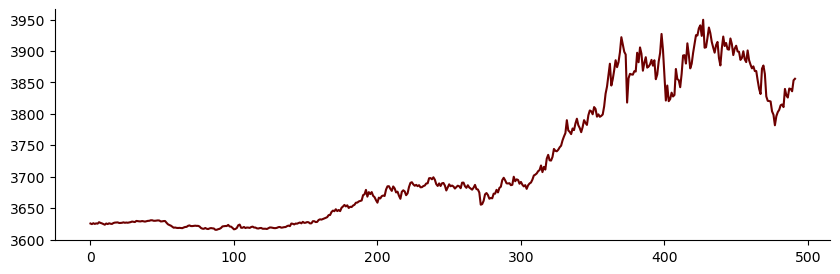

In [16]:
plt.figure(figsize=(10,3))
plt.plot(co2['y'], color = '#6d0000')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

The shape corresponds to the CO-2 price we are looking for, we also know the period of the original CO2 price index and we know the y-value of a point (the last one) --> this is enough to reconstruct the graph completely.

In [17]:
startdate = '2014-12-28 00:00:00'
enddate = '2024-05-26 00:00:00'

daterange = pd.date_range(start=startdate, end=enddate, freq='W')
co2['Date'] = daterange
co2.set_index('Date', inplace=True)

Now that we have defined the time period, we will construct the y-values.We know the x-value in SVG units, we know the y-value in SVG units and we know the y-value in €/tonne CO2.

In [18]:
# (y / 255.758)*76.510 = y_new 
# 255.758 is the old y_org
# at the date 2025-05-26 
# and y_new is the actual price at this point
co2['y_new'] = (co2['y']/(co2.loc[co2.index.max(),'y']))*76.510

We put everything into a new dataframe and interpolate on a 15-minute basis, which is the basic unit of all data in this project. 

In [19]:
co2_Prices = co2[['y_new']].resample('15T').interpolate()

Here, too, we use the formula and check the index for completeness 

In [20]:
check_complete_and_ordered_index(co2_Prices)

Index is complete and ordered
check done


#### Inflation data

Loding of the inflation index

Source: 
all countries: https://ec.europa.eu/eurostat/databrowser/view/PRC_HICP_MIDX__custom_12030913/default/table?lang=en


In [21]:
Inflation_data_neighbors = pd.read_csv('../data/raw_data/prc_hicp_midx__custom_12030913_linear.csv')
Inflation_data_neighbors['TIME_PERIOD'] = pd.to_datetime(Inflation_data_neighbors['TIME_PERIOD'], format='%Y-%m')
Inflation_data_neighbors = Inflation_data_neighbors.pivot(index = 'TIME_PERIOD', columns= 'geo', values = 'OBS_VALUE')
Inflation_data_neighbors.rename(columns= {'AT':'Austria', 'BE': 'Belgium', 'CH':'Switzerland' ,'CZ':'Czech_Republic', 'DE': 'Germany_Luxembourg', 'FR': 'France'}, inplace = True)

The inflation data are only available in monthly form, so we will interpolate them to the required time periods

In [22]:
Inflation_hourly_neighbors = Inflation_data_neighbors.resample('15T').ffill()

In [23]:
check_complete_and_ordered_index(Inflation_hourly_neighbors)

Index is complete and ordered
check done


In [24]:
Inflation_data_neighbors = Inflation_data_neighbors.interpolate(method='linear')

Inflation weekly has 3 weeks less than in our Price data set, the three weeks are added.These three weeks are also missing from our data set for the inflation index on an hourly basis. They will be added here as well.

In [25]:
Inflation_index = infaltion_interpolate(Inflation_hourly_neighbors)

In [26]:
Inflation_index.isna().sum()

geo
Austria               0
Belgium               0
Switzerland           0
Czech_Republic        0
Germany_Luxembourg    0
France                0
dtype: int64

___
## Data cleaning <a class="anchor" id="heading-3"></a>

Firstly, we provide a general overview and we create new sum columns, To improve readability, we rename the columns


In [27]:
Export_Import['Sum'] = Export_Import.loc[:, Export_Import.columns.difference(['Net export [MWh] Original resolutions'])].sum(axis = 1)
Generation['Sum [MWh]'] = Generation.loc[:, Generation.columns].sum(axis = 1)

In [28]:
Generation.rename(inplace= True, columns={
    'Biomass [MWh] Original resolutions':'Biomass',
       'Hydropower [MWh] Original resolutions':'Hydropower',
       'Wind offshore [MWh] Original resolutions':'Wind_offshore',
       'Wind onshore [MWh] Original resolutions':'Wind_onshore',
       'Photovoltaics [MWh] Original resolutions':'Photovoltaics',
       'Other renewable [MWh] Original resolutions':'Other_renewable',
       'Nuclear [MWh] Original resolutions':'Nuclear',
       'Lignite [MWh] Original resolutions':'Lignite',
       'Hard coal [MWh] Original resolutions':'Hard_coal',
       'Fossil gas [MWh] Original resolutions':'Fossil_gas',
       'Hydro pumped storage [MWh] Original resolutions':'Hydro_pumped_storage',
       'Other conventional [MWh] Original resolutions':'Other_conventional',
      'Sum [MWh]':'Generation_sum'
})

In [29]:
Consumption.rename(inplace=True, columns={
    'Total (grid load) [MWh] Original resolutions':'Total_sum',
       'Residual load [MWh] Original resolutions':'Residual',
       'Hydro pumped storage [MWh] Original resolutions':'Hydro'
})

In [30]:
Prices.rename(inplace=True, columns={
    'Germany/Luxembourg [€/MWh] Calculated resolutions':'Germany_Luxembourg',
       'Belgium [€/MWh] Calculated resolutions':'Belgium',
       'France [€/MWh] Calculated resolutions':'France',
       'Austria [€/MWh] Calculated resolutions':'Austria',
       'Czech Republic [€/MWh] Calculated resolutions':'Czech_Republic',
       'Switzerland [€/MWh] Calculated resolutions':'Switzerland',
})

In [31]:
countries = ['Belgium', 'France', 'Poland', 'Austria', 'Czech Republic', 'Switzerland']
all_contries = countries + ['Netherlands', 'Denmark', 'Luxembourg', 'Sweden', 'Norway']

Export_Import['Export_sum'] = 0
Export_Import['Import_sum'] = 0

for country in countries:
    export_col = f'{country} (export) [MWh] Original resolutions'
    import_col = f'{country} (import) [MWh] Original resolutions'
    sum_col = f'{country.replace(" ", "_")}_sum'
    Export_Import[sum_col] = Export_Import[export_col] + Export_Import[import_col]



for contries in all_contries:
    export_cols = f'{contries} (export) [MWh] Original resolutions'
    import_cols = f'{contries} (import) [MWh] Original resolutions'

    Export_Import['Export_sum'] += Export_Import[export_cols]
    Export_Import['Import_sum'] += Export_Import[import_cols]

# Calculate the remainder sum
export_import_sums = [f'{country.replace(" ", "_")}_sum' for country in countries]
Export_Import['Remainder_sum'] = Export_Import['Sum'] - Export_Import[export_import_sums].sum(axis=1)


In [32]:
Export_Import.rename(inplace=True, columns={
    'Sum':'Export_Import_sum'
})

We will not concentrate on all price zones in this model. We will only include a certain selection in the model and remove the remaining price data. We have also already created the same countries as totals columns in Export_Import, so the countries will be removed. 

In [33]:
Prices = Prices.drop(columns=
        ['Denmark 1 [€/MWh] Calculated resolutions',
       'Denmark 2 [€/MWh] Calculated resolutions',
       'Netherlands [€/MWh] Calculated resolutions',
       'Norway 2 [€/MWh] Calculated resolutions',
       'Sweden 4 [€/MWh] Calculated resolutions', 
       'Northern Italy [€/MWh] Calculated resolutions',
       'Slovenia [€/MWh] Calculated resolutions',
       'Hungary [€/MWh] Calculated resolutions'
       ])


Then we check the following:
- Are the date ranges identical?
- Are there any missing values?
    - What do the missing values mean?
- Fill in the missing values

In [34]:
print('date range:')
print('  ')
print(f'Export_Import: {Export_Import.index.min()} - {Export_Import.index.max()}')
print(f'Generation: {Generation.index.min()} - {Generation.index.max()}')
print(f'Consumption: {Consumption.index.min()} - {Consumption.index.max()}')
print(f'Prices: {Prices.index.min()} - {Prices.index.max()}')


date range:
  
Export_Import: 2015-01-01 00:00:00 - 2024-05-25 00:45:00
Generation: 2015-01-01 00:00:00 - 2024-05-25 00:45:00
Consumption: 2015-01-01 00:00:00 - 2024-05-25 00:45:00
Prices: 2015-01-01 00:00:00 - 2024-05-25 00:45:00


Now we look at the data in detail..

### Generation

First we get an overview to quantify the problem space..

In [35]:
Generation.isna().sum()

Biomass                    30
Hydropower                 30
Wind_offshore              29
Wind_onshore               31
Photovoltaics              30
Other_renewable            30
Nuclear                 11086
Lignite                    30
Hard_coal                  30
Fossil_gas                 30
Hydro_pumped_storage       31
Other_conventional         31
Generation_sum              0
dtype: int64

It looks like we have some missing values and nuclear energy has many missing values. So let's take a look at the distribution graphically. 

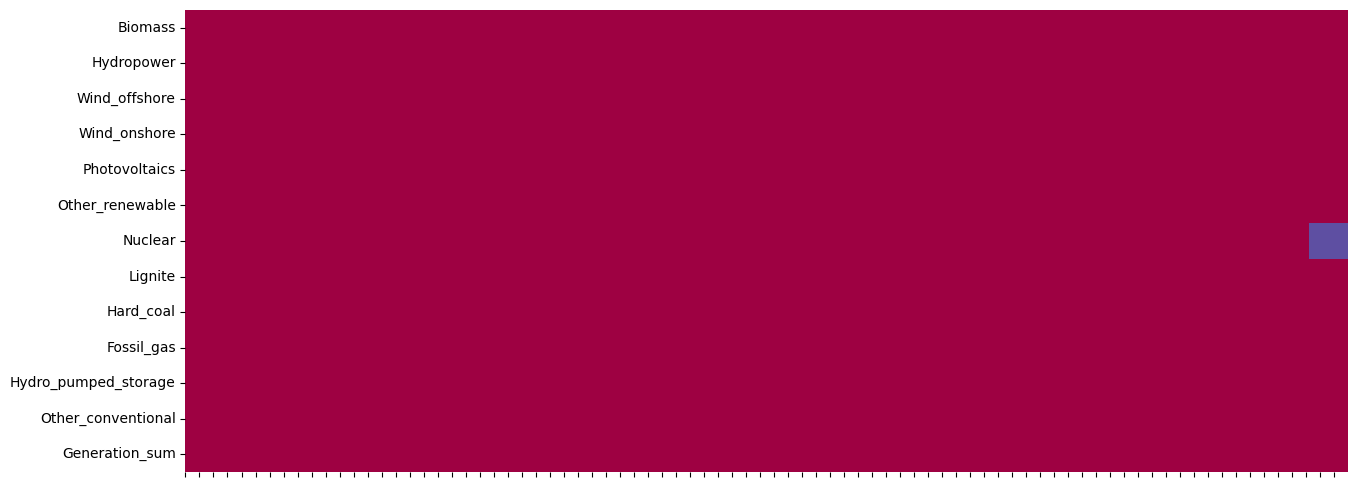

In [36]:
plt.figure(figsize=(15,6))

ax = sns.heatmap(Generation.isna().T,cbar=False, cmap="Spectral")
ax.set(xticklabels=[])

plt.show()

Nuclear power was shut down in Germany at midnight on 15 April 2023. Nuclear energy was marked as null in the data because it was not clear whether the coalition would decide to reopen the power plants due to the energy crisis in Europe caused by the Russia-Ukraine war. On 30 January 2024, nuclear energy was removed as an energy source from the data and all values are NaN. Therefore the NaN values are replaced by 0.

#### Filling of the missing values in Generation

In [37]:
Generation['Nuclear'] = Generation['Nuclear'].fillna(0)

Now we can see the moment of the last nuclear energy in Germany..

In [38]:
d = pd.to_datetime(['2023-04-15 23:30','2023-04-15 23:45', '2023-04-16 00:00','2023-04-16 00:15'])

Generation[Generation.index.isin(d)][['Nuclear']]


,Nuclear
2023-04-15 23:30:00,28.75
2023-04-15 23:45:00,12.75
2023-04-16 00:00:00,0.00
2023-04-16 00:15:00,0.00


We handle the other missing values..

In [39]:
Generation.loc[Generation.isna().any(axis =1)].head()

,Biomass,Hydropower,Wind_offshore,Wind_onshore,Photovoltaics,Other_renewable,Nuclear,Lignite,Hard_coal,Fossil_gas,Hydro_pumped_storage,Other_conventional,Generation_sum
2024-03-25 15:00:00,1086.00,420.25,36.75,982.5,6599.0,21.0,0.0,2079.25,590.25,1283.50,15.0,NaN,13113.50
2024-05-24 11:15:00,1102.75,256.00,6.00,NaN,6827.0,28.0,0.0,2179.75,554.75,1180.75,NaN,195.75,12330.75
2024-05-24 17:30:00,NaN,NaN,239.50,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,239.50
2024-05-24 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.00
2024-05-24 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.00


We see that these missing values only occur at the end of our data period, because there are few missing values, we just fill them with interpolation. 

### Consumption

First we get an overview to quantify the problem space..

In [40]:
Consumption.isna().sum()

Total_sum    32
Residual     36
Hydro        33
dtype: int64

In [41]:
Consumption.loc[Consumption.isna().any(axis =1)]

,Total_sum,Residual,Hydro
2021-01-06 08:15:00,15737.75,NaN,61.00
2021-01-06 15:45:00,16119.00,NaN,3.75
2021-01-06 17:00:00,16773.00,NaN,1.00
2024-05-24 11:15:00,13630.00,NaN,NaN
2024-05-24 17:00:00,NaN,NaN,NaN
2024-05-24 17:15:00,NaN,NaN,NaN
2024-05-24 17:30:00,NaN,NaN,NaN
2024-05-24 17:45:00,NaN,NaN,NaN
2024-05-24 18:00:00,NaN,NaN,NaN
2024-05-24 18:15:00,NaN,NaN,NaN


We see a pattern, it seems that here too most of the missing values occur more frequently from 24-05-2024. 

### Export_Import

First we also get an overview to quantify the problem space..

In [42]:
Export_Import.isna().sum()

Net export [MWh] Original resolutions                 203252
Netherlands (export) [MWh] Original resolutions         2290
Netherlands (import) [MWh] Original resolutions         2290
Switzerland (export) [MWh] Original resolutions         5203
Switzerland (import) [MWh] Original resolutions         5203
Denmark (export) [MWh] Original resolutions              554
Denmark (import) [MWh] Original resolutions              554
Czech Republic (export) [MWh] Original resolutions        32
Czech Republic (import) [MWh] Original resolutions        32
Luxembourg (export) [MWh] Original resolutions         89431
Luxembourg (import) [MWh] Original resolutions         89431
Sweden (export) [MWh] Original resolutions                32
Sweden (import) [MWh] Original resolutions                32
Austria (export) [MWh] Original resolutions               36
Austria (import) [MWh] Original resolutions               36
France (export) [MWh] Original resolutions                40
France (import) [MWh] Or

There seem to be larger phases without values here, we are looking at the matter in detail, perhaps an explanation can be found. 

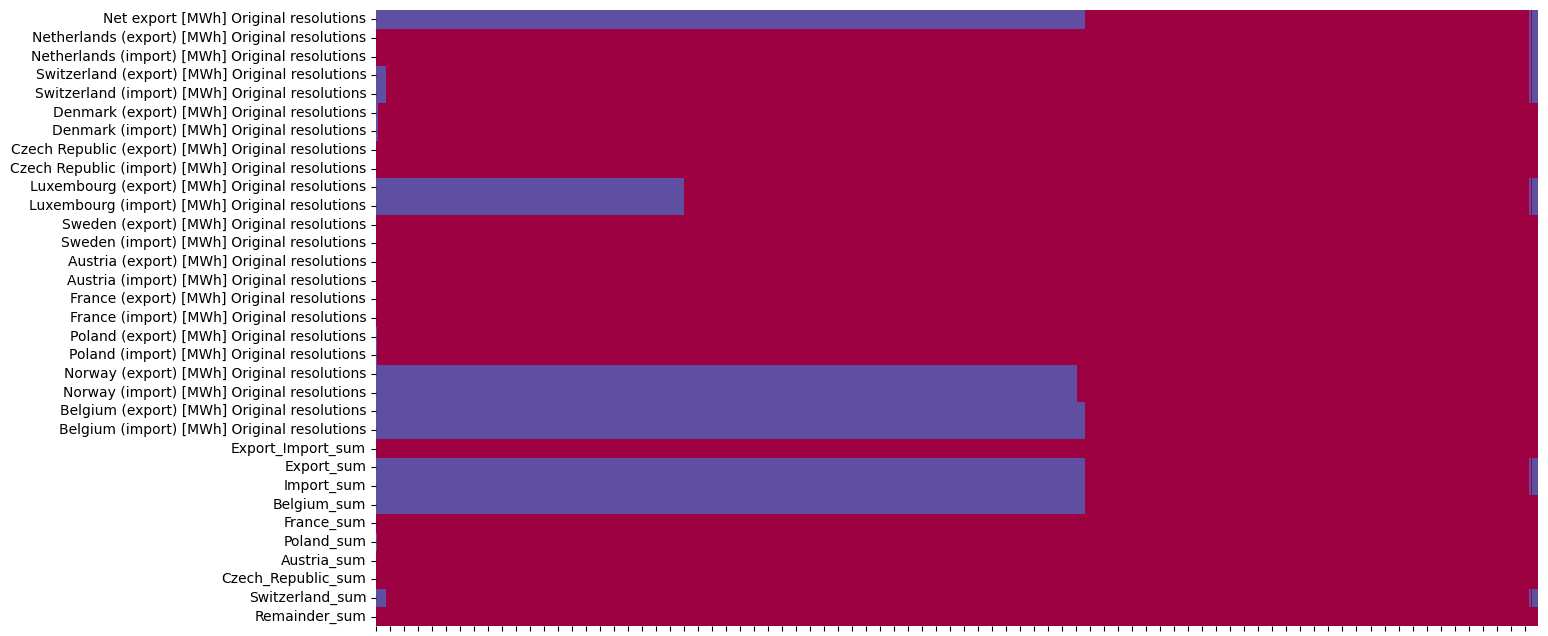

In [43]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(Export_Import.isna().T,cbar=False, cmap="Spectral")
ax.set(xticklabels=[])

plt.show()

The NaN values of our newly created totals can be explained. Net Export seems to generate NaN values if the other columns have NaN values. The physical current flow is important for the balance of demand and supply. For this reason, a sum column has already been inserted, which replaces net export and is equivalent if net export has a value. All other values are replaced with 0. net export is removed. 

In [44]:
Export_Import = Export_Import.drop('Net export [MWh] Original resolutions', axis =1 )

In [45]:
Export_Import = Export_Import.fillna(0)

To replace the net export column that has just been deleted and to shorten the table in a meaningful way and only have the countries of interest individually, we recreate the sums - this time without any NaN values 

In [46]:
countries = ['Belgium', 'France', 'Poland', 'Austria', 'Czech Republic', 'Switzerland']
all_contries = countries + ['Netherlands', 'Denmark', 'Luxembourg', 'Sweden', 'Norway']

Export_Import['Export_sum'] = 0
Export_Import['Import_sum'] = 0

for country in countries:
    export_col = f'{country} (export) [MWh] Original resolutions'
    import_col = f'{country} (import) [MWh] Original resolutions'
    sum_col = f'{country.replace(" ", "_")}_sum'
    Export_Import[sum_col] = Export_Import[export_col] + Export_Import[import_col]



for contries in all_contries:
    export_cols = f'{contries} (export) [MWh] Original resolutions'
    import_cols = f'{contries} (import) [MWh] Original resolutions'

    Export_Import['Export_sum'] += Export_Import[export_cols]
    Export_Import['Import_sum'] += Export_Import[import_cols]

# Calculate the remainder sum
export_import_sums = [f'{country.replace(" ", "_")}_sum' for country in countries]
Export_Import['Remainder_sum'] = Export_Import['Export_Import_sum'] - Export_Import[export_import_sums].sum(axis=1)


We drop the old columns to get a clean dataframe

In [47]:
Export_Import = Export_Import.drop(columns=
        ['Netherlands (export) [MWh] Original resolutions',
       'Netherlands (import) [MWh] Original resolutions',
       'Switzerland (export) [MWh] Original resolutions',
       'Switzerland (import) [MWh] Original resolutions',
       'Denmark (export) [MWh] Original resolutions',
       'Denmark (import) [MWh] Original resolutions',
       'Czech Republic (export) [MWh] Original resolutions',
       'Czech Republic (import) [MWh] Original resolutions',
       'Luxembourg (export) [MWh] Original resolutions',
       'Luxembourg (import) [MWh] Original resolutions',
       'Sweden (export) [MWh] Original resolutions',
       'Sweden (import) [MWh] Original resolutions',
       'Austria (export) [MWh] Original resolutions',
       'Austria (import) [MWh] Original resolutions',
       'France (export) [MWh] Original resolutions',
       'France (import) [MWh] Original resolutions',
       'Poland (export) [MWh] Original resolutions',
       'Poland (import) [MWh] Original resolutions',
       'Norway (export) [MWh] Original resolutions',
       'Norway (import) [MWh] Original resolutions',
       'Belgium (export) [MWh] Original resolutions',
       'Belgium (import) [MWh] Original resolutions'
       ])

In [48]:
Export_Import.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 329476 entries, 2015-01-01 00:00:00 to 2024-05-25 00:45:00
Freq: 15T
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Export_Import_sum   329476 non-null  float64
 1   Export_sum          329476 non-null  float64
 2   Import_sum          329476 non-null  float64
 3   Belgium_sum         329476 non-null  float64
 4   France_sum          329476 non-null  float64
 5   Poland_sum          329476 non-null  float64
 6   Austria_sum         329476 non-null  float64
 7   Czech_Republic_sum  329476 non-null  float64
 8   Switzerland_sum     329476 non-null  float64
 9   Remainder_sum       329476 non-null  float64
dtypes: float64(10)
memory usage: 35.7 MB


### Prices

We get another overview: 


In [49]:
Prices.isna().sum()

Germany_Luxembourg                                   131424
∅ DE/LU neighbours [€/MWh] Calculated resolutions    311620
Belgium                                                 384
France                                                  480
Austria                                              131424
Poland [€/MWh] Calculated resolutions                114028
Switzerland                                             100
Czech_Republic                                            0
DE/AT/LU [€/MWh] Calculated resolutions              198412
dtype: int64

We look to see if there is a graphical relationship between the many NaN values. 

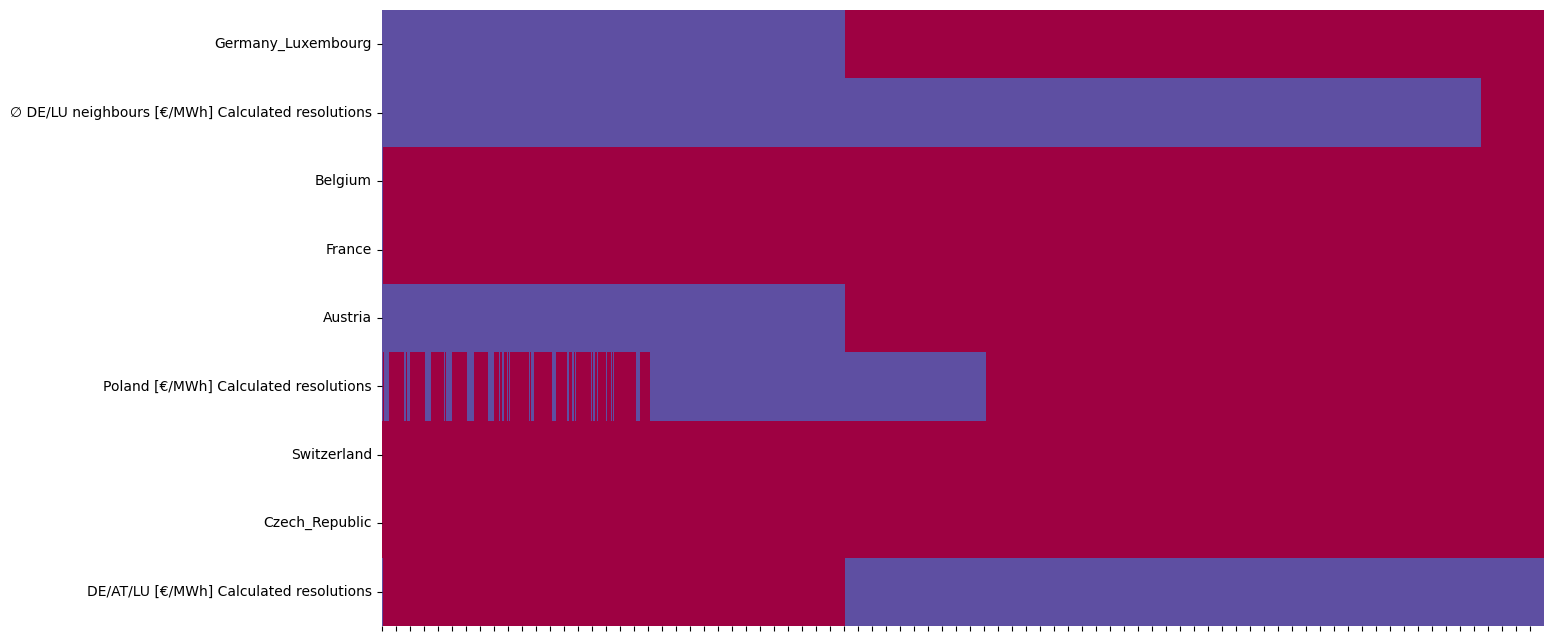

In [50]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(Prices.isna().T,cbar=False, cmap="Spectral")
ax.set(xticklabels=[])
plt.show()

In [51]:
columns = list_to_dictionary(list(Prices.columns))

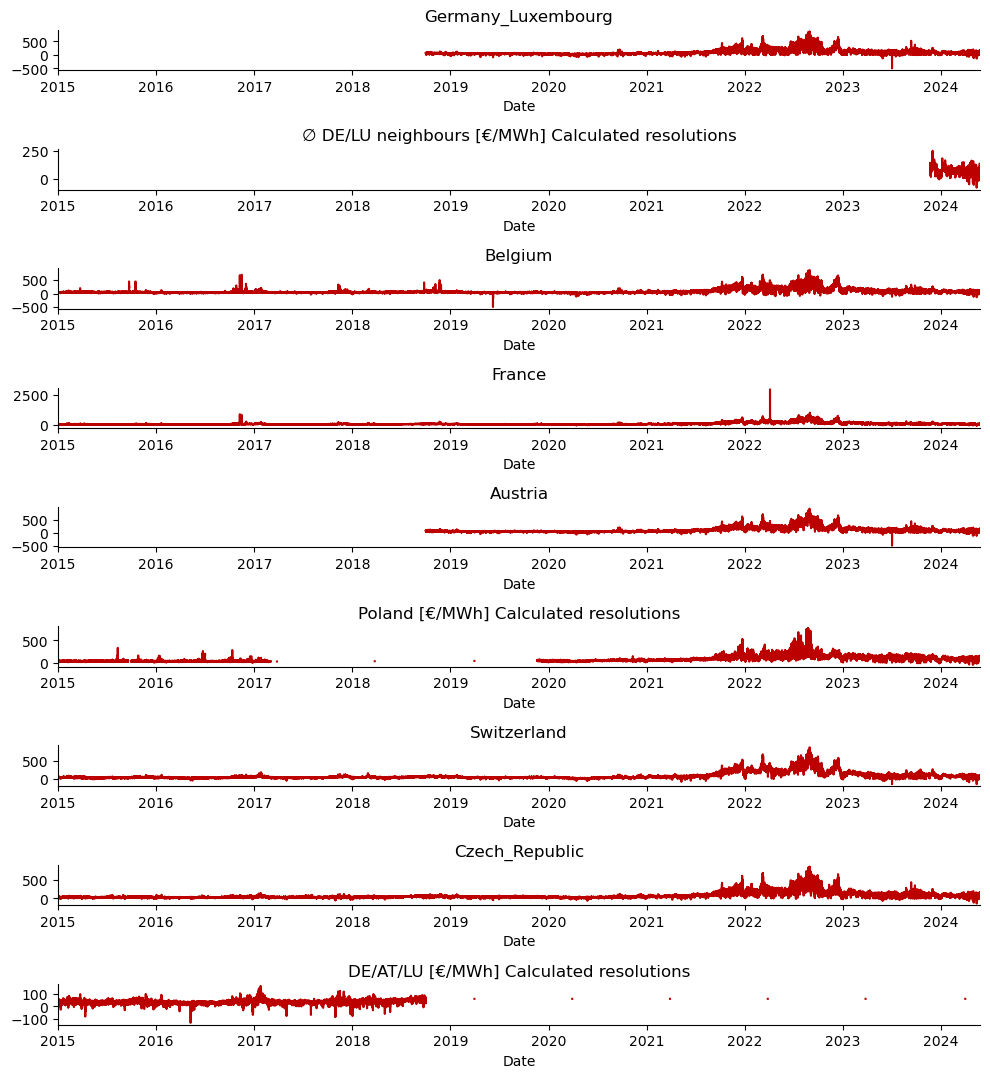

In [52]:
fig = plt.figure(figsize=(10, 20))  # Adjust figure size accordingly
gs = gridspec.GridSpec(17, 1, height_ratios=[1]*17)  # Adjust height_ratios as needed

# Set the common x-axis limits based on the overall data range
x_start = Prices.index.min()
x_end = Prices.index.max()

for k, c in columns.items():
    ax = fig.add_subplot(gs[k])
    ax.plot(Prices.index, Prices[c], color= '#bc0000')
    ax.set_title(c)
    ax.set_xlabel('Date')
    ax.set_xlim([x_start, x_end])  # Set the x-axis limits to be equal in every plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Germany, Luxembourg and Austria initially form a price zone in the data set. This ends and then splits into the Germany/Luxembourg and Austria zones.

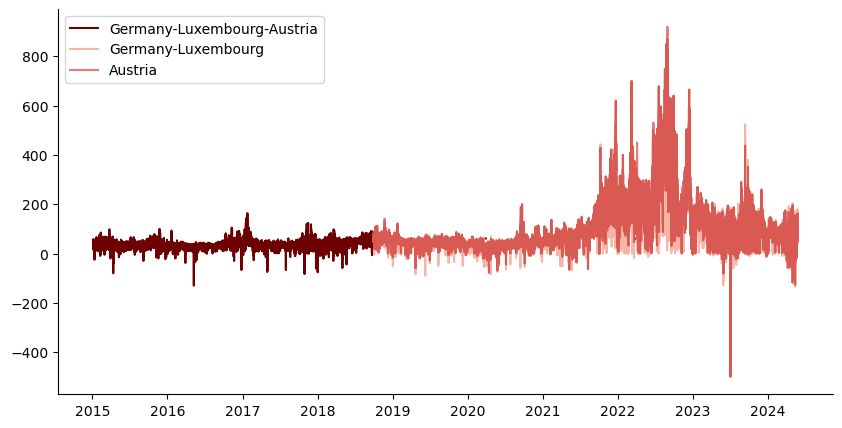

In [53]:
plt.figure(figsize=(10,5))
plt.plot(Prices.index, Prices[columns[8]],color = '#6d0000',label = "Germany-Luxembourg-Austria")
plt.plot(Prices.index, Prices[columns[0]], color ='#f6b5a6' , label = "Germany-Luxembourg")
plt.plot(Prices.index, Prices[columns[4]], color = '#bc0000', alpha = 0.5,label = "Austria")

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

The columns complement each other. The split between Germany and Luxembourg on the one side and Austria on the other took place on 30 September 2018. The columns are therefore merged.

In [54]:
Prices['Germany_Luxembourg'] = Prices['Germany_Luxembourg'].fillna(0)+Prices['DE/AT/LU [€/MWh] Calculated resolutions'].fillna(0)
Prices['Austria'] = Prices['Austria'].fillna(0)+Prices['DE/AT/LU [€/MWh] Calculated resolutions'].fillna(0)

We drop all the other columns.. 

In [55]:
Prices = Prices.drop('DE/AT/LU [€/MWh] Calculated resolutions', axis = 1)
Prices = Prices.drop('∅ DE/LU neighbours [€/MWh] Calculated resolutions', axis = 1)
Prices = Prices.drop('Poland [€/MWh] Calculated resolutions', axis = 1)

In [56]:
Prices.loc[Prices.isna().any(axis=1)]

,Germany_Luxembourg,Belgium,France,Austria,Switzerland,Czech_Republic
2015-01-01 00:00:00,0.00,NaN,NaN,0.00,44.94,26.48
2015-01-01 00:15:00,0.00,NaN,NaN,0.00,44.94,26.48
2015-01-01 00:30:00,0.00,NaN,NaN,0.00,44.94,26.48
2015-01-01 00:45:00,0.00,NaN,NaN,0.00,44.94,26.48
2015-01-01 01:00:00,0.00,NaN,NaN,0.00,43.43,24.20
...,...,...,...,...,...,...
2017-07-19 23:45:00,32.97,36.04,NaN,32.97,40.01,32.50
2024-05-25 00:00:00,94.88,94.88,94.88,94.88,NaN,94.88
2024-05-25 00:15:00,94.88,94.88,94.88,94.88,NaN,94.88
2024-05-25 00:30:00,94.88,94.88,94.88,94.88,NaN,94.88


In [57]:
Prices = Prices.interpolate().fillna(method='ffill').fillna(method='bfill')

To take into account the missing values in the other tables from 24-05-24, we will shorten the data records accordingly up to 23-05-24 and fill in the remaining values by interpolation. Also because the price data from our target area is not complete the first days we therefore shorten the data a bit.

In [58]:
Generation = Generation.loc[(Generation.index <'2024-05-24 00:00:00')&(Generation.index >'2015-01-04 23:45:00')]
Consumption = Consumption.loc[(Consumption.index <'2024-05-24 00:00:00')&(Consumption.index >'2015-01-04 23:45:00')]
Export_Import = Export_Import.loc[(Export_Import.index <'2024-05-24 00:00:00')&(Export_Import.index >'2015-01-04 23:45:00')]
Prices = Prices.loc[(Prices.index <'2024-05-24 00:00:00')&(Prices.index >'2015-01-04 23:45:00')]
co2_Prices = co2_Prices.loc[(co2_Prices.index <'2024-05-24 00:00:00')&(co2_Prices.index >'2015-01-04 23:45:00')]
Inflation_index = Inflation_index.loc[(Inflation_index.index <'2024-05-24 00:00:00')&(Inflation_index.index >'2015-01-04 23:45:00')]

We fill in the missing values by interpolation after separating them into consumption and generation. 

In [59]:
Consumption = Consumption.interpolate()
Generation = Generation.interpolate()

last sanity check before the export

In [60]:
print('date range:')
print('  ')
print(f'Export_Import: {Export_Import.index.min()} - {Export_Import.index.max()}')
print(f'Generation: {Generation.index.min()} - {Generation.index.max()}')
print(f'Consumption: {Consumption.index.min()} - {Consumption.index.max()}')
print(f'Prices: {Prices.index.min()} - {Prices.index.max()}')
print(f'Inflation_index: {Inflation_index.index.min()} - {Inflation_index.index.max()}')
print(f'co2_Prices: {co2_Prices.index.min()} - {co2_Prices.index.max()}')

date range:
  
Export_Import: 2015-01-05 00:00:00 - 2024-05-23 23:45:00
Generation: 2015-01-05 00:00:00 - 2024-05-23 23:45:00
Consumption: 2015-01-05 00:00:00 - 2024-05-23 23:45:00
Prices: 2015-01-05 00:00:00 - 2024-05-23 23:45:00
Inflation_index: 2015-01-05 00:00:00 - 2024-05-23 23:45:00
co2_Prices: 2015-01-05 00:00:00 - 2024-05-23 23:45:00


All data in the period between 01-05-2015 and 23-05-2024 is now available at 15-minute intervals. We export these in CSV form for the further steps of the EDA, preparation for modelling and modelling, which follow after this notebook.

___
## Export <a class="anchor" id="heading-4"></a>

In [61]:
Prices.to_csv('../data/Prices.csv', index= True)
Export_Import.to_csv('../data/Export_Import.csv', index= True)
Consumption.to_csv('../data/Consumption.csv', index= True)
Generation.to_csv('../data/Generation.csv', index= True)
co2_Prices.to_csv('../data/co2_Prices.csv', index=True)
Inflation_index.to_csv('../data/Inflation_index.csv', index = True)

___
#### Conclusion / Next Steps

After we have cleaned up the data, we will now continue with the EDA, please refer to [Notebook No. 2.](02-eda.ipynb)

___